In [1]:
import json
import pickle
import logging
import os
import warnings

import joblib
import mlflow
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

### Model building baseline with mlflow tracking 

#### Carga de la data

In [2]:
def read_csv(file_name: str, path="../data/data_procesada") -> pd.DataFrame:
    """
    Read csv file
    :param file_name: file name
    :param path: path to the file
    :return: pandas dataframe
    """
    return pd.read_csv(os.path.join(path, file_name))

In [3]:
df_tickets = read_csv("tickets_inputs_eng_1.csv")
print(df_tickets.shape)
df_tickets.sample(5)

(18961, 4)


,complaint_what_happened,ticket_classification,processed_text,relevant_topics
1978,On XX/XX/XXXX I purchased a flight scheduled f...,Credit card or prepaid card + General-purpose ...,purchas flight schedul use mile valu use ban...,Bank Account Services
408,I opened a Chase Card for my wife. The card ac...,Credit card or prepaid card + General-purpose ...,chase card wife card account number payment ti...,Mortgage/Loan
2154,How are you? Im extremely upset and shocked ab...,Debt collection + Credit card debt,im extrem way account report credit report inc...,Credit Report or Prepaid Card
12083,Chase card services pulled my XXXX credit fil...,"Credit reporting, credit repair services, or o...",card servic pull credit file consent 2018 appl...,Credit Report or Prepaid Card
1847,"In the month of XX/XX/2019, the bank chase, cl...",Checking or savings account + Checking account,month bank chase account return account claim ...,Bank Account Services


In [4]:
df_tickets.relevant_topics.value_counts() 

#originalmente lo indicaba como desbalanceado, al corregir los archivos del util los clasifica correctamente 
#por lo que no hay un gran desbalance

relevant_topics
Bank Account Services            7069
Credit Report or Prepaid Card    6295
Mortgage/Loan                    5597
Name: count, dtype: int64

#### Definición de funciones

Se definen las funciones que se usaran en la creación, evaluación y trackeo de modelos

In [5]:
# Toma el dataframe y lo devuelve en variables de entrada (X) y variables de salida (y)
# Como variables de entrada tendremos el texto procesado
# Como variable de salida (este es mi target) el tema relevante

def data_transform(df: pd.DataFrame):
    
    X = df["processed_text"]
    y = df["relevant_topics"]

    return X, y

In [6]:
# Toma el json donde se encuentra la descripción e id de los temas relevantes y devuelve un diccionario.
# Esto permite la conversion de los id de los temas relevantes a su descripción,
# facilitando la lectura de los resultados

def read_idx2label(json_path: str) -> pd.Series:
    
    with open(json_path) as f:
        idx2label = json.load(f)
    
    return idx2label

In [7]:
# Similar a la anterior pero al revés, transforma los temas relevantes a los id 

def decode_labels_into_idx(labels: pd.Series, idx2label: dict) -> pd.Series:

    return labels.map(idx2label)

In [8]:
# genera un objeto CountVectorizer con los valores de entrada
# CountVectorizer es una matriz que presenta, como columnas, todas las palabras (tokens en este caso) del corpus
# y, como filas, todos los tickets. Indica en cada ticket la cantidad de veces que aparece cada tokens
# este objeto es guardado en la carpeta auxiliares de data

def fit_transform(X: pd.Series) -> np.ndarray:
    
    count_vectorizer = CountVectorizer()
    X_vectorized = count_vectorizer.fit_transform(X)

    joblib.dump(count_vectorizer, '../data/auxiliares/count_vectorizer.pkl')
    logger.info("count vectorizer trained successfully stored")
    
    return X_vectorized

In [9]:
# genera un objeto TfidfTransformer con los valores del CountVectorizer
# TfidfTransformer es una matriz que presenta lo relevante que es una palabra (en este caso Token) según su aparición
# en dicho documento y su presencia en el corpus. Tal cual hace el TfidfVectorizer (explicado en utils). La diferencia 
# surge ya que TfidfVectorizer lo calcula directamente del documento, mientras que TfidfTransformer 
# necesito pasar primero por CountVectorizer
# este objeto es guardado en la carpeta auxiliares de data

def transform_tfidf(X_vectorized: object) -> np.ndarray:
    
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_vectorized)
    joblib.dump(X_tfidf, '../data/auxiliares/X_tfidf.pkl')
    logger.info("X_tfidf trained successfully stored")
    
    return X_tfidf

In [10]:
# serializa la data pasada y lo guarda en un archivo  pickle
# la serialización permite al usuario preservar el estado original del objeto 
# sin perder ninguna información relevante

def save_pickle(data, filename) -> None:

    filepath = os.path.join("..", "data", "auxiliares", f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)

In [11]:
# separa la data en train y test, y lo guarda como un pickle

def split_train_test(X_tfidf: np.array, y: pd.Series, 
                     test_size: float = 0.3, random_state: int = 42) -> tuple:
   
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=random_state
    )
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test),  "test")
    logger.info("data saved successfully in pickle files")
    
    return X_train, X_test, y_train, y_test

In [46]:
# toma el modelo, realiza las predicciones y muestra el reporte de la clasificación
# y devuelvo las métricas

def display_classification_report( model: object, 
                                  name_model: str, developer: str, 
                                  X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array,
                                  use_cv = False ):
       
    # inicializo el tracking,
    with mlflow.start_run(run_name=name_model):

        # logeo el modelo para trackearlos
        mlflow.sklearn.log_model(model, f"model_{name_model}")

        # logeo los parámetros para trackearlos
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)

        # Por las dudas vacío las métricas
        metric = []

        #realizo las perdiciones
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        
        # calculo los score utilizando curvas ROC. (enfrenta el ratio de falsos positivos  
        # con el ratio de falsos negativos )
        roc_auc_score_train = round( roc_auc_score(
            y_train, y_train_pred_proba, average="weighted", multi_class="ovr"
            ), 2)
        roc_auc_score_test = round( roc_auc_score(
            y_test, y_test_pred_proba, average="weighted", multi_class="ovr"
            ), 2)

        print("ROC AUC Score Train:", roc_auc_score_train)
        print("ROC AUC Score Test:", roc_auc_score_test)

        # realizo las perdiciones y calculamos las métricas
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        ( precision_train, recall_train, 
         fscore_train, support_train ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        
        ( precision_test, recall_test, 
         fscore_test, support_test ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        # logeo las métricas
        # logeo las métricas roc_auc de train y test para trackearlos
        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)
        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)

        #calculo la exactitud y la imprimo
        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)
        
        # agrego los valores a las métricas
        metric.extend([roc_auc_score_train, roc_auc_score_test])
        metric.extend([
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ])
        print('Métricas:', metric)

        # obtengo los mejores parámetros del modelo, dependiendo de que si definí el uso de validación cruzada o no
        # y lo trackeo
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)

        except AttributeError as e:
            logger.info(f"Error: {e}")     
        
        # obtengo un reporte e imprimo
        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)


        # Ploteo la matriz de confusion 
        fig, ax = plt.subplots(figsize=(5, 5))

        # Creo la matriz de confusion 
        decoded_y_test_pred = [idx2label[idx] for idx in y_test_pred]
        decoded_y_test = [idx2label[idx] for idx in y_test]

        cm = confusion_matrix(decoded_y_test, decoded_y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=list(idx2label.values()))
        cmp.plot(ax=ax)

        plt.xticks(rotation=10, transform_rotates_text=True, horizontalalignment='right', verticalalignment='top')
        plt.show()

        #return metric



In [13]:
# realiza la búsqueda por grilla

def grid_search(model, folds, params, scoring):

    grid_search = GridSearchCV(
        model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1
    )

    return grid_search

In [14]:
# imprima el mejor score y los hyperparametros correspondientes

def print_best_score_params(model):
    """This functions print best score and best hyperparameters for baselines models
    Args:
        model (object): model
    Returns:
        None"""
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

#### Iniciar trackeo y preparar data

Para generar el archivo de base de datos (.db) y usarlo como tracking, ejecuto desde linea de comando:

```bash
mlflow ui --backend-store-uri sqlite:///tracking/mlflow.db
```

In [15]:
# Seteamos el archivo de tracking y el nombre del experimento:

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("tickets_baseline")

INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
2024/02/23 14:46:45 INFO mlflow.tracking.fluent: Experiment with name 'tickets_baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///d:/Disco d/Milesi/01 - Personal/platzi/07 - Curso de '
 'MLOPS/tracking/mlruns/1'), creation_time=1708710405737, experiment_id='1', last_update_time=1708710405737, lifecycle_stage='active', name='tickets_baseline', tags={}>

In [35]:
#cargo los id y las etiquetas del target (y)
idx2label = read_idx2label(json_path="../data/data_procesada/topic_mapping_1.json")
label2idx = {value: key for key, value in idx2label.items()}

# cargo la data y cambio los id por las etiquetas del target
X, y = data_transform(df_tickets)
y = decode_labels_into_idx(labels=y, idx2label=label2idx)

# genero las matrices de relevancia
X_vectorized = fit_transform(X.values)
X_tfidf = transform_tfidf(X_vectorized)

# separo la data
X_train, X_test, y_train, y_test = split_train_test(X_tfidf, y)

INFO:__main__:count vectorizer trained successfully stored
INFO:__main__:X_tfidf trained successfully stored
INFO:__main__:data saved successfully in pickle files


In [19]:
# mlflow.end_run()

<h2 style="color: pink;">Modelo Multinomial Naive Bayes</h2>


ROC AUC Score Train: 0.97
ROC AUC Score Test: 0.96
Train Accuracy:  0.88
Test Accuracy:  0.86
Métricas: [0.97, 0.96, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86]
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4937
           1       0.87      0.88      0.87      4429
           2       0.93      0.81      0.87      3906

    accuracy                           0.88     13272
   macro avg       0.88      0.87      0.88     13272
weighted avg       0.88      0.88      0.88     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      2132
           1       0.84      0.85      0.84      1866
           2       0.92      0.79      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.85      0.86      5689
weighted avg       0.86      0.86      0.86      5689



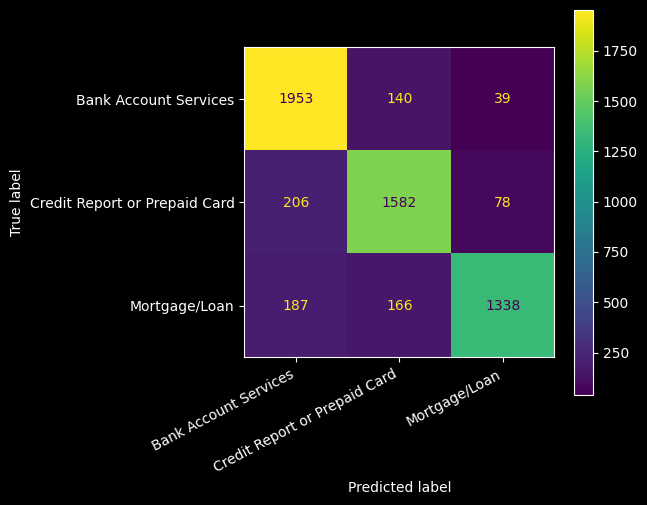

In [47]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="MultinomialNB", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

<h2 style="color: pink;">Modelo Multinomial Naive Bayes con GreadSearch</h2>

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Best Score:  0.8473478684769604
Best Hyperparameters:  {'alpha': 1}
ROC AUC Score Train: 0.97
ROC AUC Score Test: 0.96
Train Accuracy:  0.88
Test Accuracy:  0.86
Métricas: [0.97, 0.96, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86]
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4937
           1       0.87      0.88      0.87      4429
           2       0.93      0.81      0.87      3906

    accuracy                           0.88     13272
   macro avg       0.88      0.87      0.88     13272
weighted avg       0.88      0.88      0.88     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      2132
           1       0.84      0.85      0.84      1866
           2       0.92      0.79      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.85      0.86    

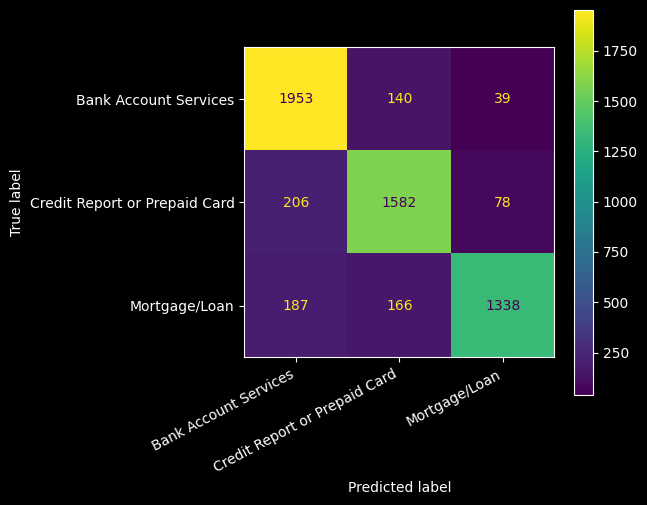

In [48]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)
mnb = MultinomialNB()
mnb_params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring="f1_micro")
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model=grid_search_mnb, 
                              name_model="MultinomialNBCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv= True)

<h2 style="color: pink;">Logistic Regression</h2>

ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy:  0.99
Test Accuracy:  0.97
Métricas: [1.0, 1.0, 0.99, 0.97, 0.99, 0.97, 0.99, 0.97, 0.99, 0.97]
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4937
           1       0.98      1.00      0.99      4429
           2       1.00      0.98      0.99      3906

    accuracy                           0.99     13272
   macro avg       0.99      0.99      0.99     13272
weighted avg       0.99      0.99      0.99     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2132
           1       0.96      0.98      0.97      1866
           2       0.98      0.96      0.97      1691

    accuracy                           0.97      5689
   macro avg       0.97      0.97      0.97      5689
weighted avg       0.97      0.97      0.97      5689



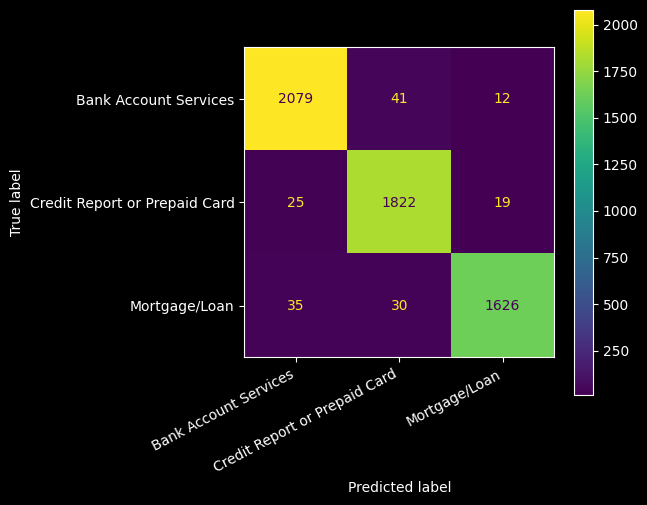

In [49]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
display_classification_report(model=log_reg, 
                              name_model="LogisticRegression", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=False)

<h2 style="color: pink;">Logistic Regression with GreadSearch</h2>

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.9837283507622596
Best Hyperparameters:  {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy:  1.0
Test Accuracy:  0.98
Métricas: [1.0, 1.0, 1.0, 0.98, 1.0, 0.98, 1.0, 0.98, 1.0, 0.98]
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4937
           1       1.00      1.00      1.00      4937
           2       1.00      1.00      1.00      4937

    accuracy                           1.00     14811
   macro avg       1.00      1.00      1.00     14811
weighted avg       1.00      1.00      1.00     14811

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      2132
           1       0.98      0.98      0.98      1866
           2       0.98      0.99      0.98      1691

    accuracy     

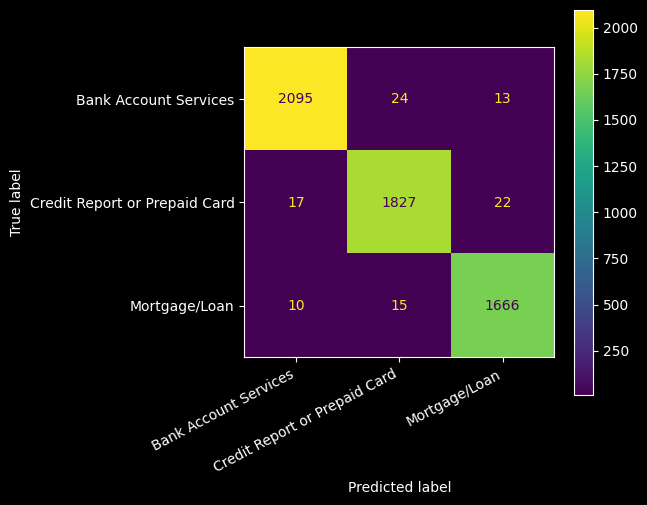

In [50]:
# rebalance of the data
smote = SMOTE()
# transform the dataset with the SMOTE algorithm
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# define the model with the balanced class_weight
log_reg = LogisticRegression(class_weight='balanced')

log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

grid_search_log = grid_search(log_reg, folds, log_params, scoring="f1_micro")
grid_search_log.fit(X_train_res, y_train_res)  # entrenamiento con los datos rebalanceados

print_best_score_params(grid_search_log)
display_classification_report(grid_search_log,
                              name_model="LogisticRegressionCVSmote", 
                              developer="Maria", 
                              X_train=X_train_res,  # evaluación con los datos rebalanceados
                              X_test=X_test, 
                              y_train=y_train_res,  # etiquetas rebalanceadas
                              y_test=y_test, 
                              use_cv=True)

<h2 style="color: pink;">Decision Tree Classifier</h2>

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.89
Train Accuracy:  1.0
Test Accuracy:  0.86
Métricas: [1.0, 0.89, 1.0, 0.86, 1.0, 0.86, 1.0, 0.86, 1.0, 0.86]
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4937
           1       1.00      1.00      1.00      4429
           2       1.00      1.00      1.00      3906

    accuracy                           1.00     13272
   macro avg       1.00      1.00      1.00     13272
weighted avg       1.00      1.00      1.00     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2132
           1       0.86      0.86      0.86      1866
           2       0.85      0.85      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.86      0.86      5689
weighted avg       0.86      0.86      0.86      5689



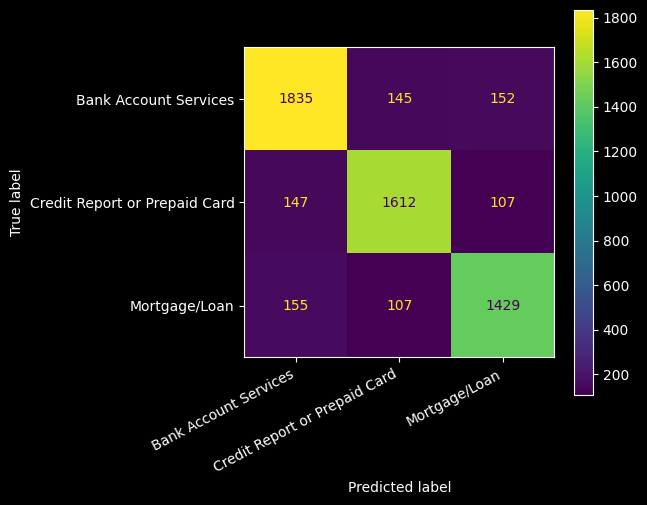

In [51]:
dtc = DecisionTreeClassifier(random_state=40)
dtc.fit(X_train,y_train)
display_classification_report(model=dtc,
                              name_model="DecisionTreeClassifier",
                              developer="Maria",
                              X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test,
                              use_cv=False)

<h2 style="color: pink;">Decision Tree Classifier with Gread Search</h2>

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best Score:  0.870619206133405
Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 7, 'splitter': 'best'}
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.94
Train Accuracy:  0.94
Test Accuracy:  0.87
Métricas: [1.0, 0.94, 0.94, 0.87, 0.94, 0.87, 0.94, 0.87, 0.94, 0.87]
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      4937
           1       0.94      0.96      0.95      4429
           2       0.95      0.93      0.94      3906

    accuracy                           0.94     13272
   macro avg       0.94      0.94      0.94     13272
weighted avg       0.94      0.94      0.94     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2132
           1       0.86      0.89      0.88      1866

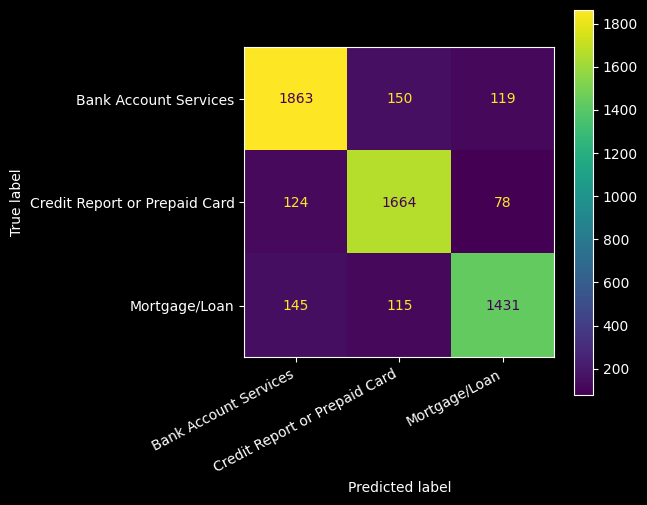

In [53]:
# decis|on tree classifier with grid search
dtc_cv = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2,3,4,5,6,7,8,None],
    'min_samples_leaf': [2,3,4,7],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
grid_search_dtc = grid_search(dtc_cv, folds, dtc_params, scoring='f1_macro')
grid_search_dtc.fit(X_train, y_train)
print_best_score_params(grid_search_dtc)
display_classification_report(grid_search_dtc, 
                              name_model="DecisionTreeClassifierCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=True)

* No olvides ejecutar 

    ```bash
    mlflow ui --backend-store-uri sqlite:///tracking/mlflow.db
    ```
    para visualizar los resultados